In [1]:
import pandas as pd
from collections import Counter
import numpy as nm
import matplotlib.pyplot as plt
import warnings
import random
import datetime
warnings.filterwarnings("ignore")
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import cv2 as cv2
import os
import math as m
  

## Negative comments identification
### File Loading & Text Preprocessing

In [2]:
'''
data= pd.read_json("review.json", lines=True, chunksize=100000)
i=1
for c in data:
    c.to_csv("review"+str(i)+".csv", index=False)
    i=i+1
'''   

'\ndata= pd.read_json("review.json", lines=True, chunksize=100000)\ni=1\nfor c in data:\n    c.to_csv("review"+str(i)+".csv", index=False)\n    i=i+1\n'

In [3]:
def prepareData(number, fileName):
    df= pd.DataFrame(columns=["stars", 'text'])
    for c in range(1,number+1):#67
        m=pd.read_csv(fileName+str(c)+".csv")
        
        df=df.append(pd.DataFrame(m[['stars','text']]) ,ignore_index=True)
    df['text']=df['text'].str.replace('\d+', '')
    df= df.dropna(axis=0, how="any")
    print("-------------Missing values--------------")
    print(df.isna().sum())
    print("-----------------------------------------")
    return df

def cleanData(df):
    df['text']=df['text'].apply(lambda x:str(x).translate(str.maketrans('', '', string.punctuation)).lower().rstrip())
    words=stopwords.words('english')
    arr=[]
    for el in df['text']:
        pp=''
        var=el.split()
        for i in var:
            if not i in words:
                pp=pp+i+' '
        arr.append(pp)
    return arr


In [4]:
df= prepareData(3, "review")
df['text']= cleanData(df)
df['text']

-------------Missing values--------------
stars    0
text     0
dtype: int64
-----------------------------------------


0         total bill horrible service gs crooks actually...
1         adore travis hard rocks new kelly cardenas sal...
2         say office really together organized friendly ...
3         went lunch steak sandwich delicious caesar sal...
4         today second three sessions paid although firs...
                                ...                        
299995    truly love great staff knowledgable really car...
299996    worst beer ive ever zero food seriously let ex...
299997    first time location looks recently remodeled a...
299998    loveee bahama bucks used go one back home texa...
299999    review car wash ownership fraudulent practices...
Name: text, Length: 300000, dtype: object

### Splitting dataset into :
- positive comments
- negative comments
- neutral comments

To identify bad buzz we will work with negative

#### Stars ordinal variable distribution before comments allocation

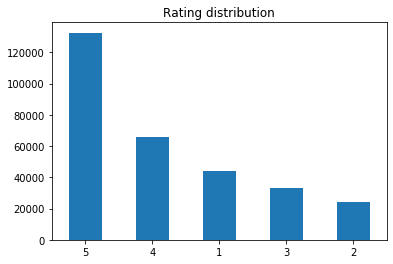

In [5]:
df['stars'].value_counts().plot(kind='bar', rot=0, title="Rating distribution")

In [6]:
positive= df[df['stars']>3]

In [7]:
negative= df[df['stars']<3]

In [8]:
neutral= df[df['stars']==3]

#### Comments allocation into three categories

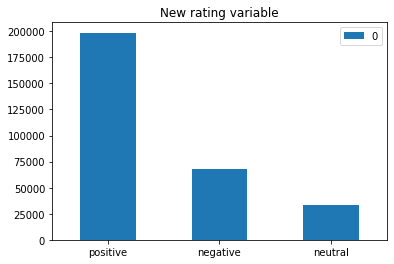

In [9]:
vals=[len(positive['stars']),len(negative['stars']),len(neutral['stars'])]
ind=['positive','negative', 'neutral']
pd.DataFrame(vals, index=ind).plot(kind='bar', rot=0, title="New rating variable")

### Selecting words that can identify positive and neutral comments
We want to avoid those words in negative comments analysis, because they can represent differnt types of comments
- number 500, available at the least in 20 docs and at the most in 99%. Features of one and two words are accepted
- applied lemmatization


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
def getUsedEverywhere(data1, data2):
    vectorizer2 = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(1,2), min_df=100, max_df=0.99,max_features=300)
    X2 = vectorizer2.fit_transform(data1)
    featpos=vectorizer2.get_feature_names()
    X2 = vectorizer2.fit_transform(data2)
    featneu=vectorizer2.get_feature_names()

    for i in featpos:
        if not i in featneu:
            featneu.append(i)
    return featneu

def createBOW(data3,typ, words, m):
    if(typ==True):
        tfidfconverter = TfidfVectorizer(tokenizer=LemmaTokenizer(), max_features=500, min_df=m, max_df=0.9, ngram_range=(1,2),stop_words=words)  
    else:
        tfidfconverter = CountVectorizer(tokenizer=LemmaTokenizer(),analyzer='word', ngram_range=(1, 2), min_df=5, max_df=0.9,max_features=500, stop_words=words)
    X = tfidfconverter.fit_transform(data3)
    df = pd.DataFrame(X.toarray(), columns=tfidfconverter.get_feature_names())
    return df


#### Testing text processing functions

In [11]:
strin = "I believe, I have not eaten this type of food for a week!"
strin2 = "No Way, Never Again!!!...."
strin=pd.DataFrame({'stars':[1], 'text':[strin]})
strin.to_csv('test1.csv', mode='w', index= False, header=strin.columns)
strin=pd.DataFrame({'stars':[2], 'text':[strin2]})
strin.to_csv('test2.csv', mode='w', index= False, header=strin.columns)
strin= prepareData(2,"test")
print(strin)
strin = cleanData(strin)
print(strin)
strin=createBOW(strin,True, [],1)
strin


-------------Missing values--------------
stars    0
text     0
dtype: int64
-----------------------------------------
  stars                                               text
0     1  I believe, I have not eaten this type of food ...
1     2                         No Way, Never Again!!!....
['believe eaten type food week ', 'way never ']


,believe,believe eaten,eaten,eaten type,food,food week,never,type,type food,way,way never,week
0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.00000,0.333333,0.333333,0.00000,0.00000,0.333333
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000,0.000000,0.57735,0.57735,0.000000


### Creating BOW by using TF- IDF measurments
- lemmatization
- 500 fetuares
- ngrams: 1,2
- stopwords: presented in other neutral and negative comments( as well as english stopwords that have been removed earlier)


In [12]:
removeWords=getUsedEverywhere(positive['text'], neutral['text'])
bowtfidf=createBOW(negative['text'],True,removeWords,5)
#bowcount= createBOW(negative['text'],False,removeWords)

In [13]:
bowtfidf

,account,across,add,added,additional,ago,ahead,air,airport,along,...,worse,worst,wow,write,wrong,yelp,yes,yet,young,zero
0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.083139,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.074298,0.0,0.0,0.086099,0.000000,0.000000
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.250472,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68210,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
68211,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
68212,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
68213,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.145652,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.203868


### BOW Analysis
- Sum per vector of BOW to find more relevant terms for corpus
- 30 most relevant terms to negative comments


In [86]:
bowtfidf.sum().sort_values(ascending=False).head(30)

worst          1464.021476
rude           1404.965615
manager        1402.701312
money          1392.503579
horrible       1355.048840
call           1315.514992
terrible       1238.413688
wont           1153.284358
employee       1038.305923
waited         1018.933787
company         993.194950
phone           949.526125
tell            944.021821
min             903.455095
wrong           897.989262
couldnt         864.337237
finally         857.805676
poor            849.630506
walked          846.547439
month           844.424594
later           840.311151
charge          826.986140
paid            811.168783
bland           804.534464
return          801.941377
problem         795.868735
door            777.179332
appointment     769.321799
stay            760.928577
bill            733.820738
dtype: float64

### Negaive comments have various topics( reason for the comments), lets try to see some general tendencies
- combine words that belongs to various topic and reduce the dimentions
- 15 topics to be chosen

In [14]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=15, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(bowtfidf)

### 10 most important words per each topic

In [15]:
do=pd.DataFrame(index=bowtfidf.columns)
count=0
ftrs=pd.DataFrame(index=range(1,10))
for i in lda.components_:
    
    d= pd.DataFrame(i,index=bowtfidf.columns,columns=[count])
    uu=pd.DataFrame(d.sort_values(by=[count],ascending=False).index[:10])
    ftrs[count]=uu
    do[count]=d
    count=count+1
      
ftrs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,burrito,crab,terrible,employee,min,driver,company,cut,overpriced,credit,can not,closed,party,floor,waste
2,disappointing,rib,smell,worst,seated,pool,appointment,lady,suck,cash,not,thru,club,bathroom,waste money
3,bean,oil,gross,wash,sat,bed,phone,salon,decor,manager,impressed,flight,glass,door,groupon
4,bowl,thai,son,horrible,wing,rental,office,tip,poor,credit card,burnt,wife,loud,street,save
5,onion,salt,disgusting,manager,finally,coupon,doctor,massage,salty,bag,mexican,airport,mediocre,walk,sale
6,salsa,sick,bacon,tire,hostess,company,month,color,bbq,receipt,serve,window,bottle,across,avoid
7,soggy,ate,cheap,cashier,empty,online,insurance,foot,real,register,anymore,ticket,birthday,light,buy
8,lettuce,game,frozen,working,walked,desk,issue,worker,attitude,cause,gone,tonight,dress,school,spend
9,tomato,lobster,eaten,counter,manager,stay,problem,girl,sad,purchase,awful,seat,forever,kitchen,class


### Topics 3D Visualization with help of TSNE

In [72]:
from sklearn.manifold import TSNE
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
def visualize(do,columns, cat=None):
    model = TSNE(n_components = 3, perplexity = 50)
    tsne_data = model.fit_transform(do)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(tsne_data)
    
    dataV=pd.DataFrame(x_scaled, columns=["D1","D2","D3"])
    if cat!=None:
        dataV['cat']=cat
    for i in dataV:
        sd= 1*dataV[i].std()
        mean=dataV[i].mean()
    
        a=dataV[i].apply(lambda x:x if x> mean-sd  else mean-sd)
        dataV[i]=  a.apply(lambda x: x if  x< mean+sd  else mean+sd)
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(111, projection='3d')
    plt.title("3D visualization BOW", loc='left')

    xs = dataV["D1"]
    ys = dataV["D2"]
    zs= dataV["D3"]
    scatter=ax.scatter(xs, ys, zs, c=dataV['cat'], s=50, alpha=0.6, edgecolors='w')
    plt.colorbar(scatter)

    ax.set_xlabel('Dimention 1')
    ax.set_ylabel('Dimention 2')
    ax.set_zlabel('Dimention 3', rotation=90)
    m=0
    for  x, y, z in zip( xs, ys, zs):
    
        label = columns[m]
        ax.text(x, y, z,  label)
        m=m+1


#### Visualization of words with help of tSNE
- every word provides value for each topic
- tSNE is applied on 15 topics
- words containg in the topics are ploted in 3D
- dimention reduction is applied on topics


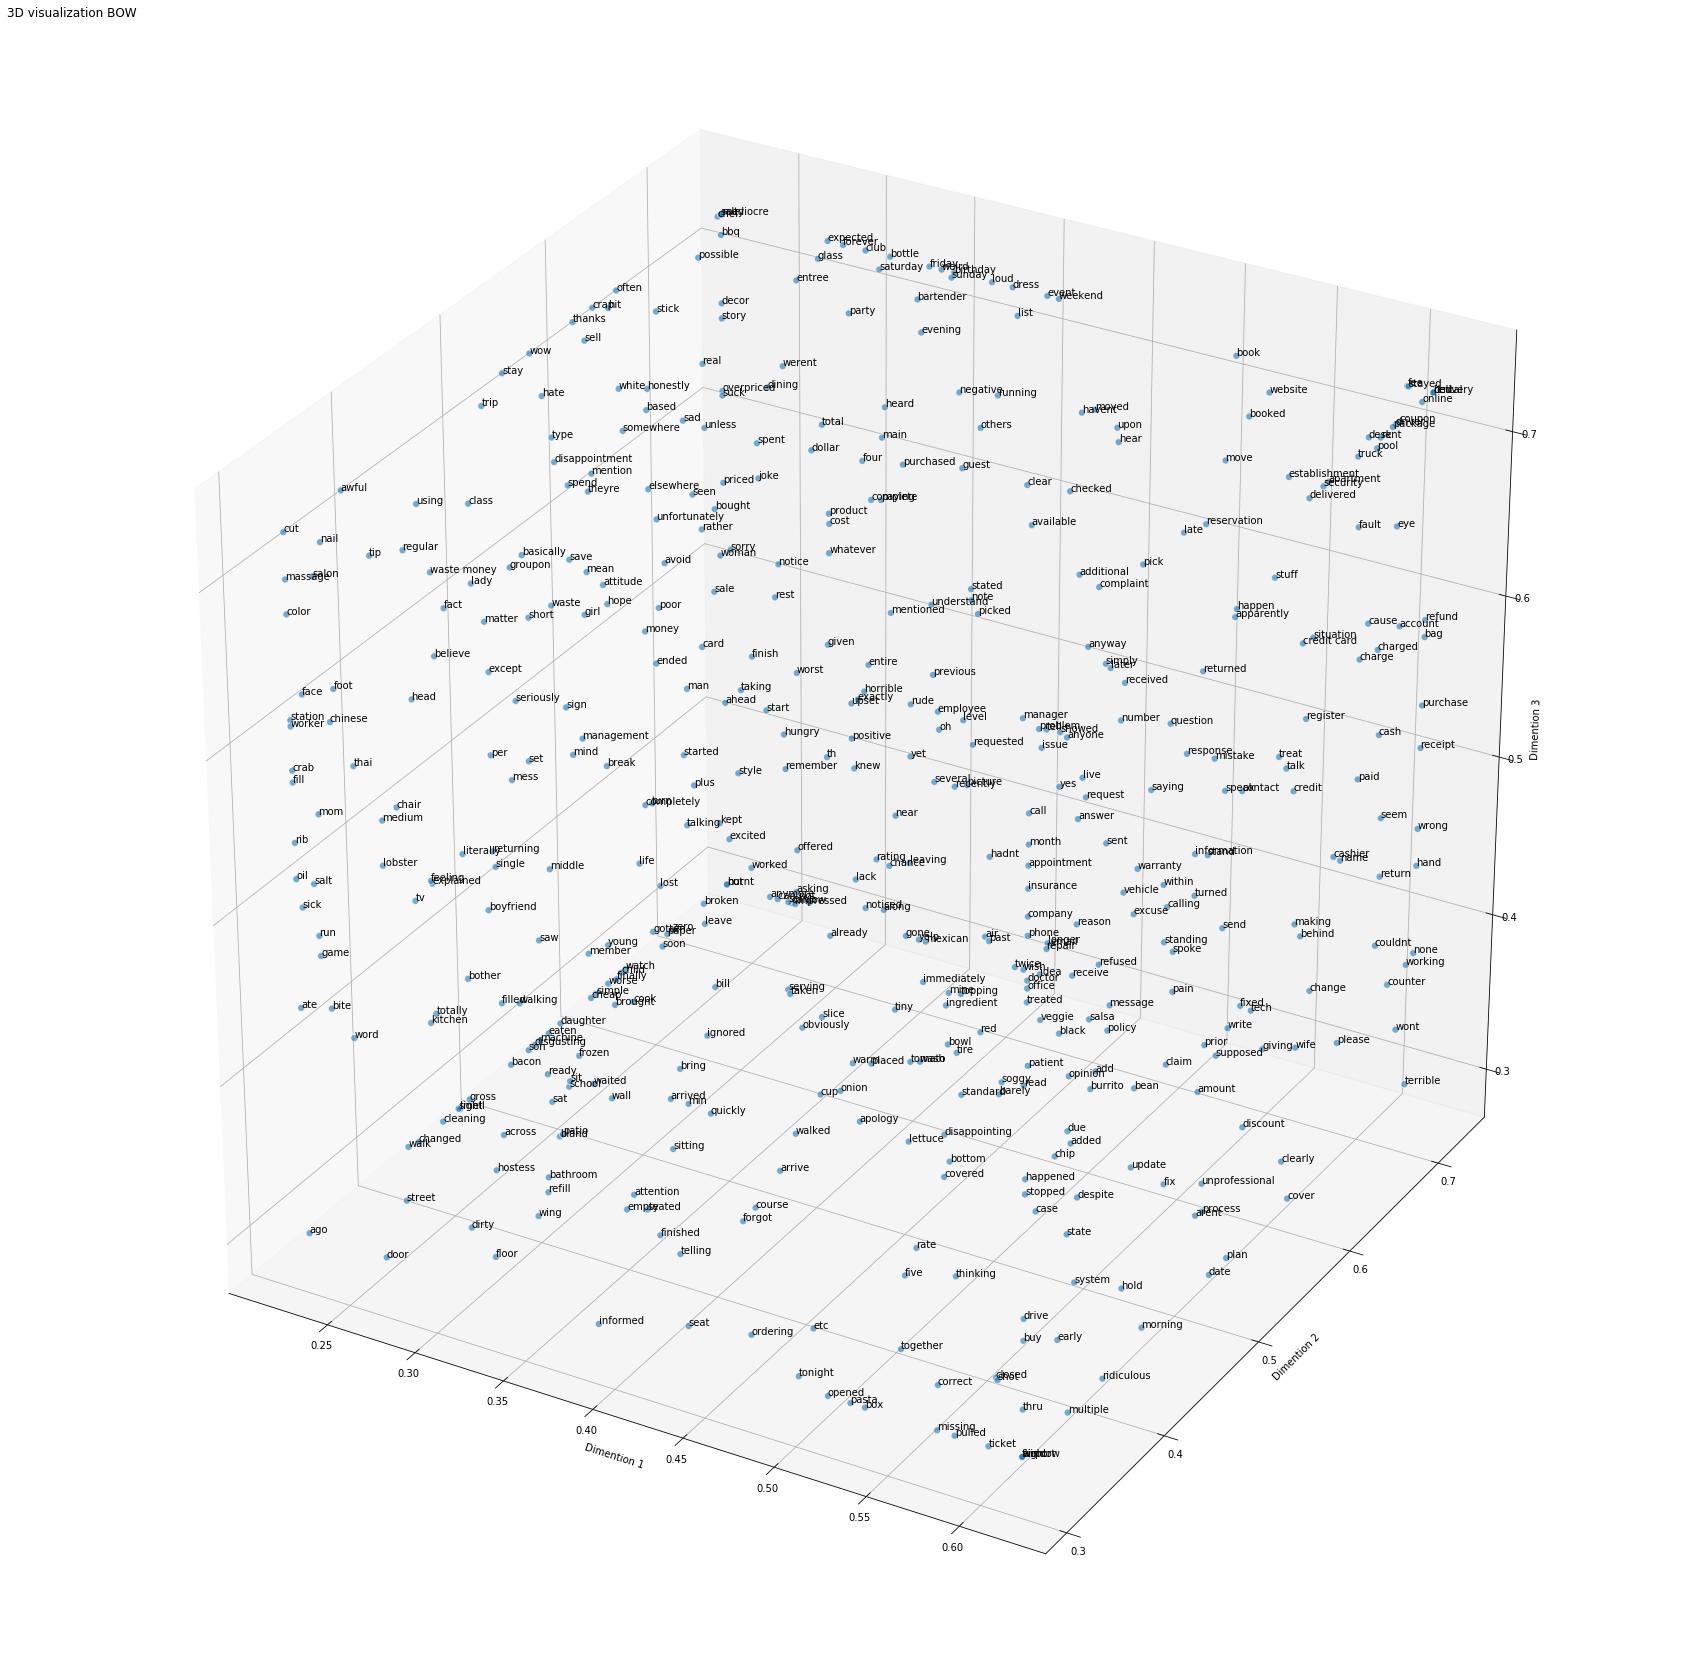

In [106]:
visualize(do,bowtfidf.columns)


#### Topics visualization in 3D
- every topic provides value for each word 
- topics are ploted in 3D
- dimention reduction is applied on words


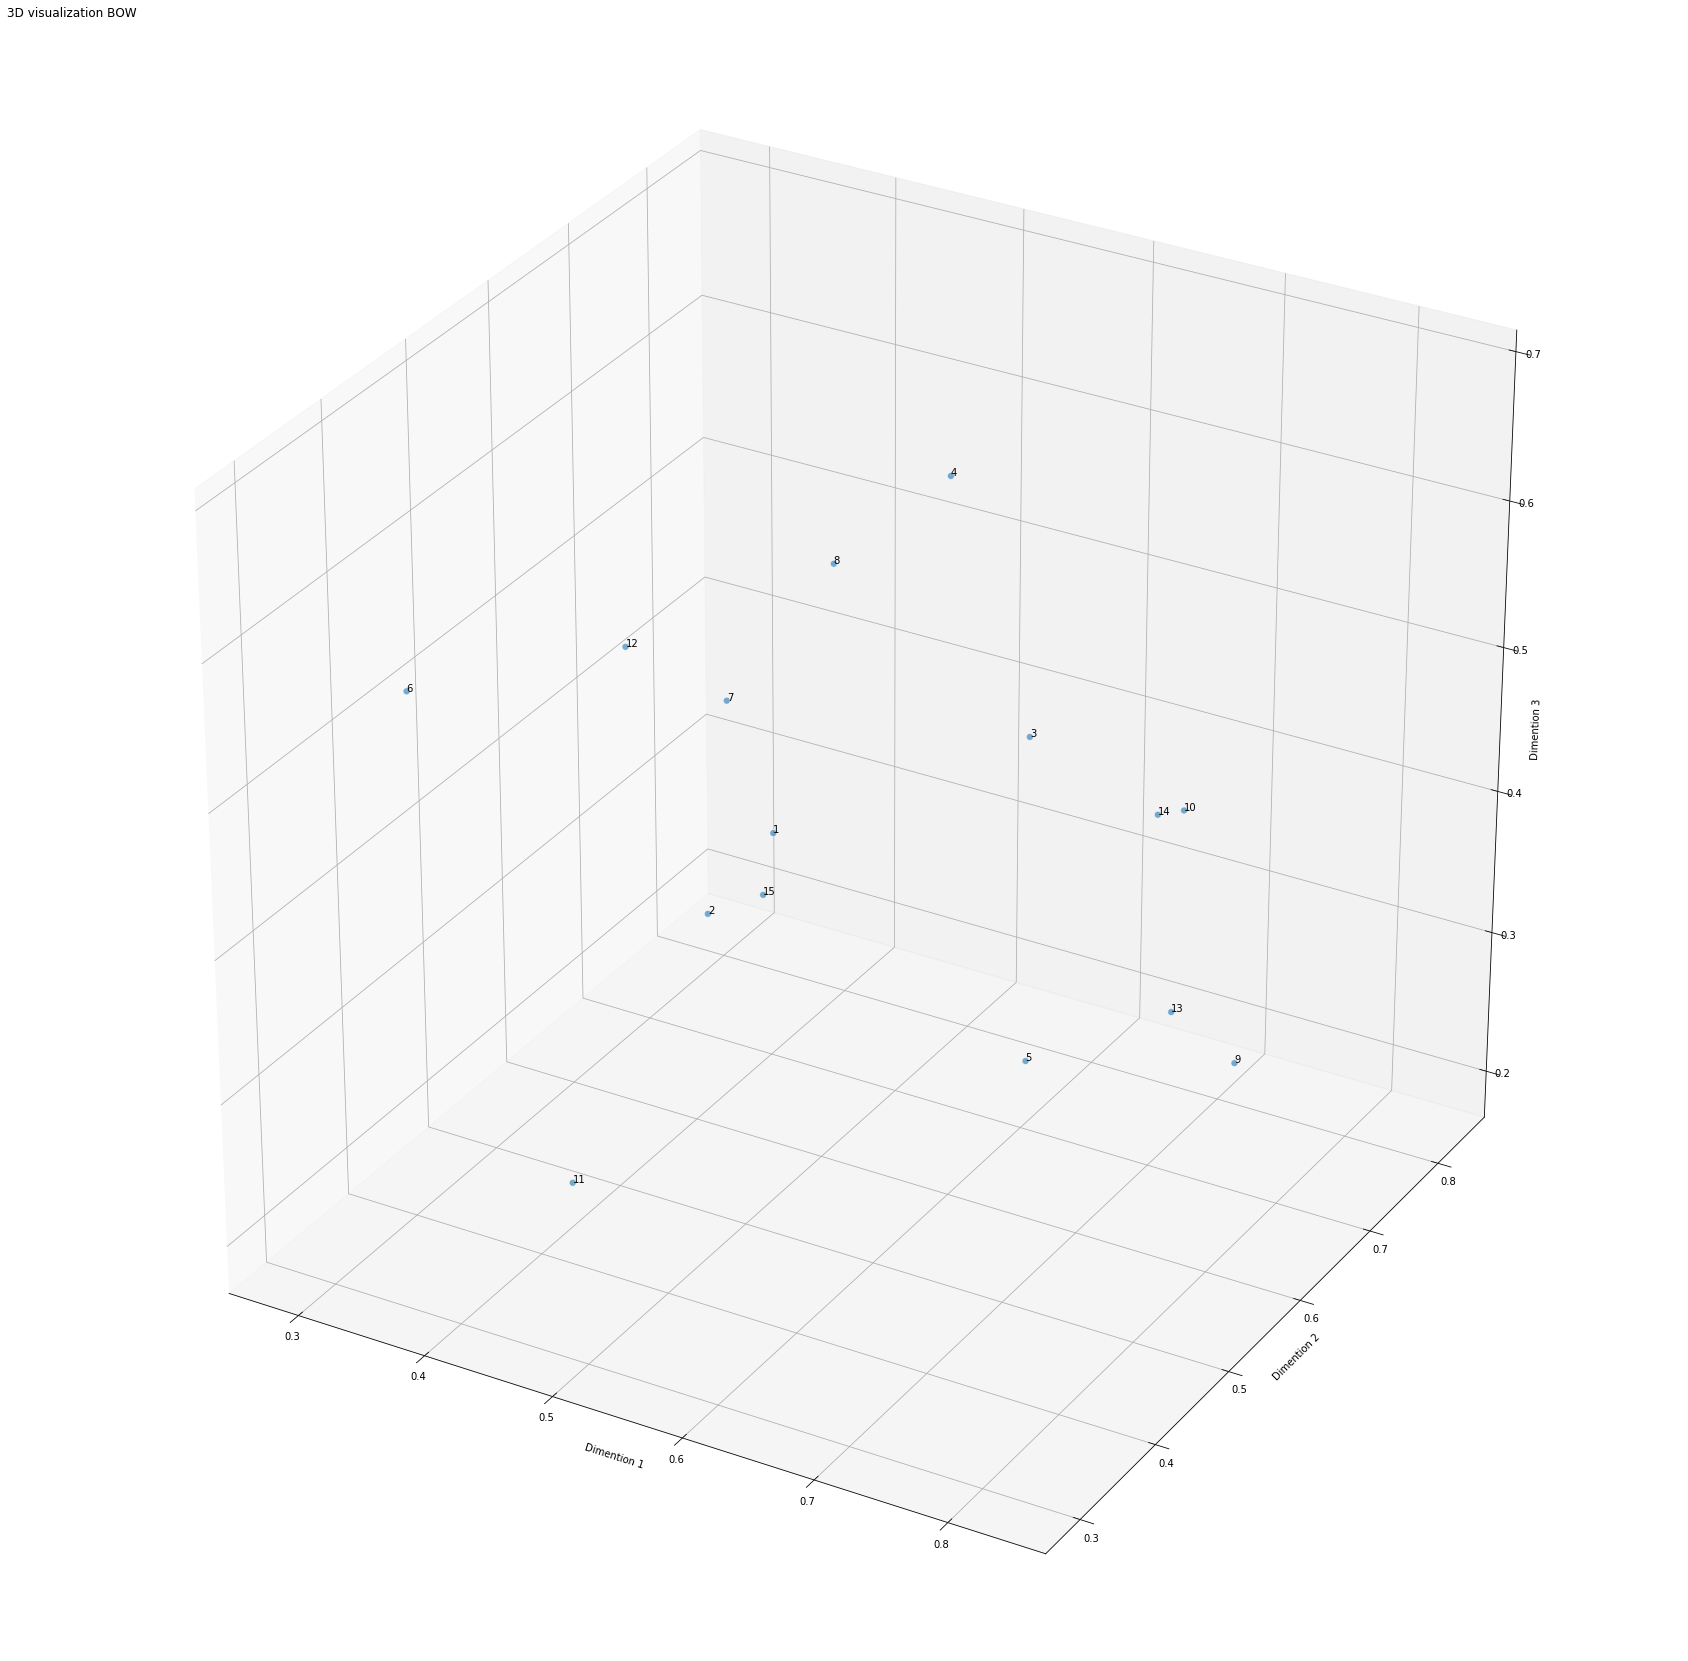

In [108]:
visualize(do.T,range(1,16))

#### Visualization of words/fetuares with help of tSNE
- BOW Features are plotted on 3D scatter plot
- every word provides value for a document
- dimention reduction is applied on the document number

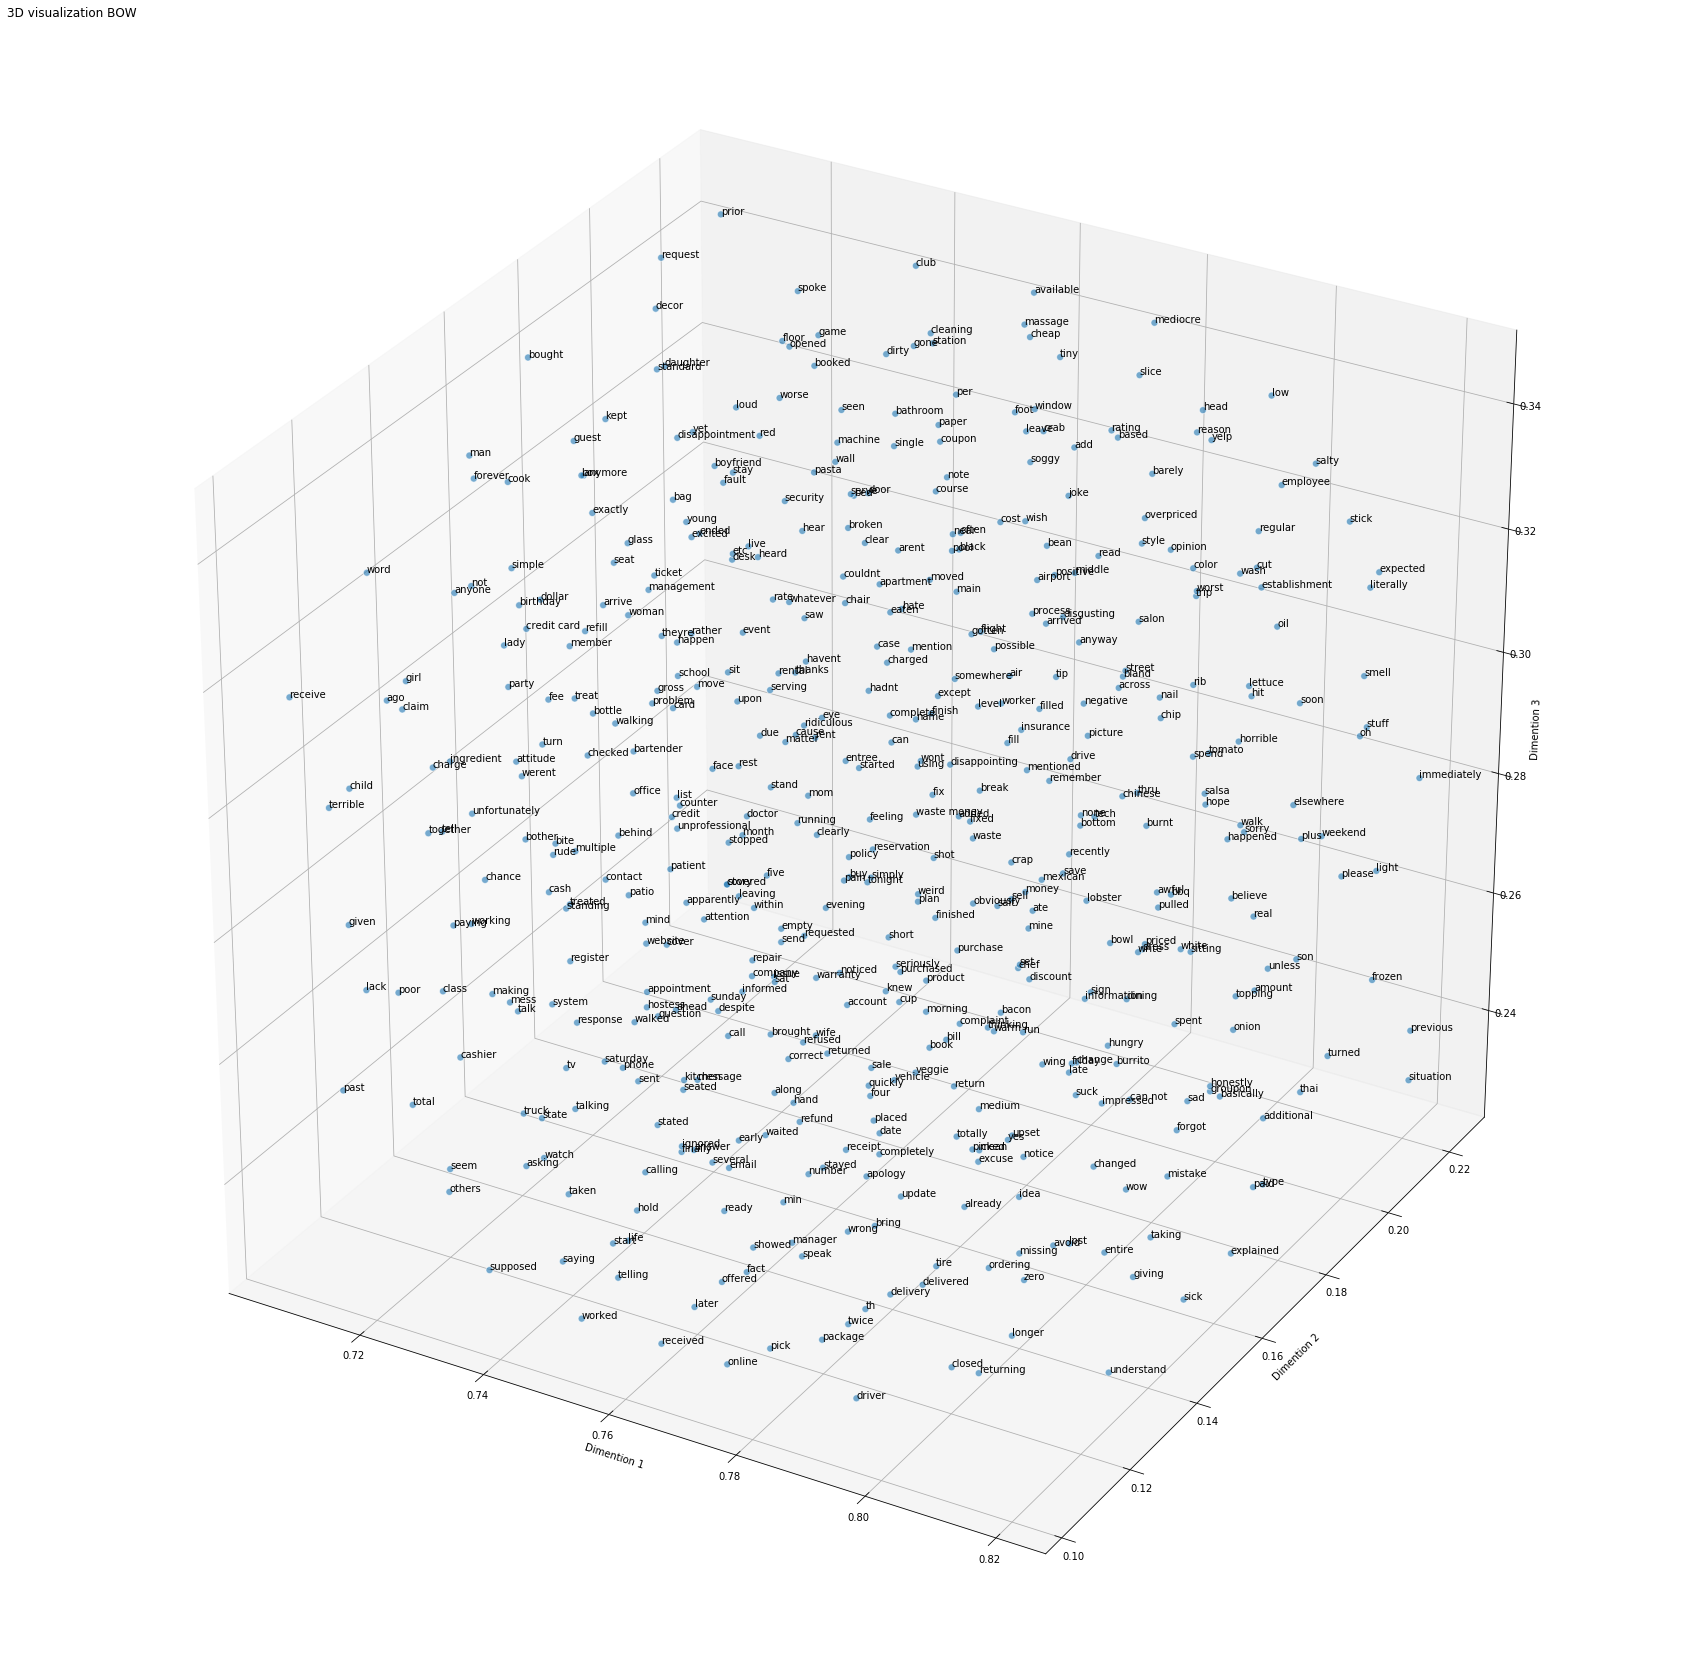

In [109]:
visualize(bowtfidf.T,bowtfidf.columns)


## Photo classification
The dataset contains the following labels

In [24]:
photosData= pd.read_json("photo.json", lines=True)

In [25]:
mo=photosData['label'].value_counts()
mo

food       114874
inside      52448
drink       18121
outside     11534
menu         3023
Name: label, dtype: int64

### Available Photos

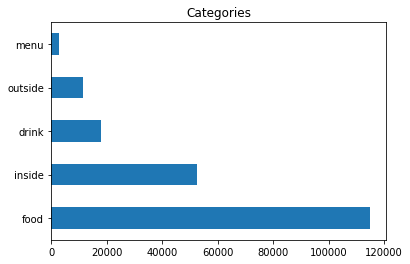

In [26]:
mo.plot(kind="barh", title='Categories')

### Sorting photos into corresponding folders

In [27]:
import shutil
for i, row in photosData.iterrows():
    label= row['label']
    id=row['photo_id']
    if os.path.isfile("yelp_photos/photos/"+id+".jpg"):
        os.rename("yelp_photos/photos/"+id+".jpg", "yelp_photos/"+label+"/"+id+".jpg")

In [28]:

def getFeatures(path,sampleSize):
    allFeatures=[]
    hh=0
    for filename in os.listdir(path):
        
        ll=preProcess(path,filename)
        rr=runORB(ll)
        allFeatures.append(rr[1])#array[ImageNb][FeatureNb]
        hh=hh+1
        if(hh==sampleSize):
            return allFeatures
    

def preProcess(path,filename):
    img = cv2.imread(path+filename)
    img1 = cv2.resize(img, (240,240), interpolation = cv2.INTER_AREA)
    mask = nm.zeros(img1.shape[:2],nm.uint8)
    bgdModel = nm.zeros((1,65),nm.float64)
    fgdModel = nm.zeros((1,65),nm.float64)
    rect = (5,5,235,235)
    cv2.grabCut(img1,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
    mask2 = nm.where((mask==2)|(mask==0),0,1).astype('uint8')
    img1 = img1*mask2[:,:,nm.newaxis]
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    cv2.fastNlMeansDenoising(img1, img1)
    ll=cv2.equalizeHist(img1)
    return ll


def runORB(ll):
    orb = cv2.ORB_create(nfeatures=100)
    keypoints, descriptors = orb.detectAndCompute(ll, None)
    return [keypoints, descriptors]

    

In [90]:
def runKmeans(allFeatures):
    kmeans = KMeans(n_clusters = 200, n_init=10)
    gg=[item for sublist in allFeatures for item in sublist]
    kmeans.fit(gg)#vocabulary
    #visual_words = kmeans.cluster_centers_
    return kmeans


In [30]:

def calcTf(kmeans, allFeatures):
    alla=[]
    for i in allFeatures:
        clusters=[]
        for u in i:
            cluster=kmeans.predict([u])  
            clusters.append(cluster[0])
        
        nums=pd.Series(clusters).value_counts()
        tf=nums.apply(lambda a:a/nums.sum())
        alla.append(tf.to_dict())
#tf for each feature in the document
    return alla

def calcDocsPerFeature(alla,clusters):
    documentsPerFeature=[0] * clusters
    for i in alla:
        for k in i:
            documentsPerFeature[k-1]=documentsPerFeature[k-1]+1
#number of documents containing the feature
    return documentsPerFeature

def calcTfIdf(alla,documentsPerFeature):
    fr= pd.DataFrame(columns= range(1,201))
    for i in alla:
        row=[0]*200
        totalWords=0
        for k in i:
            idf=m.log(len(alla)/documentsPerFeature[k-1])
            res=i[k]*idf
            row[k]=res
        fr=fr.append(pd.Series(row, range(1,201)),ignore_index=True )  
    return fr   

### Image preprocessing
- background removal
- noise removal
- histogram equalization
- resize to 240x240

### Extracting features from n images with help of ORB
- sample of 200 photos
- each photo gets up to 100 features

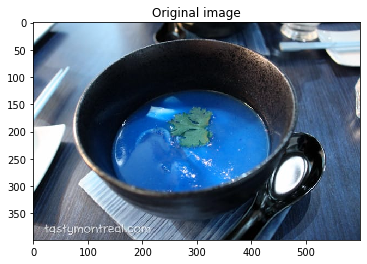

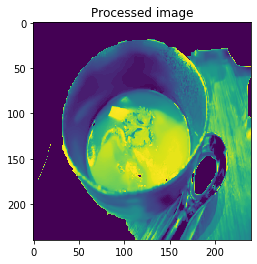

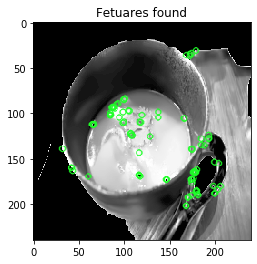

In [31]:
#Tesing image processing and feature generating functions
im= cv2.imread("yelp_photos/food/photo1.jpg")
plt.imshow(im)
plt.title("Original image")
plt.show()
im=preProcess("yelp_photos/food/","photo1.jpg")
plt.title("Processed image")
plt.imshow(im)
plt.show()
ress= runORB(im)
im=cv2.drawKeypoints(im,ress[0],im,color=(30,255,40), flags=0)
plt.title("Fetuares found")
plt.imshow(im)
plt.show()


In [32]:
allFeatures=getFeatures('yelp_photos/food/',200)


### Clustering into n clusters
- 200 clusters
- visualizing in 3D with help of tSNE

In [33]:
kmeans=runKmeans(allFeatures)

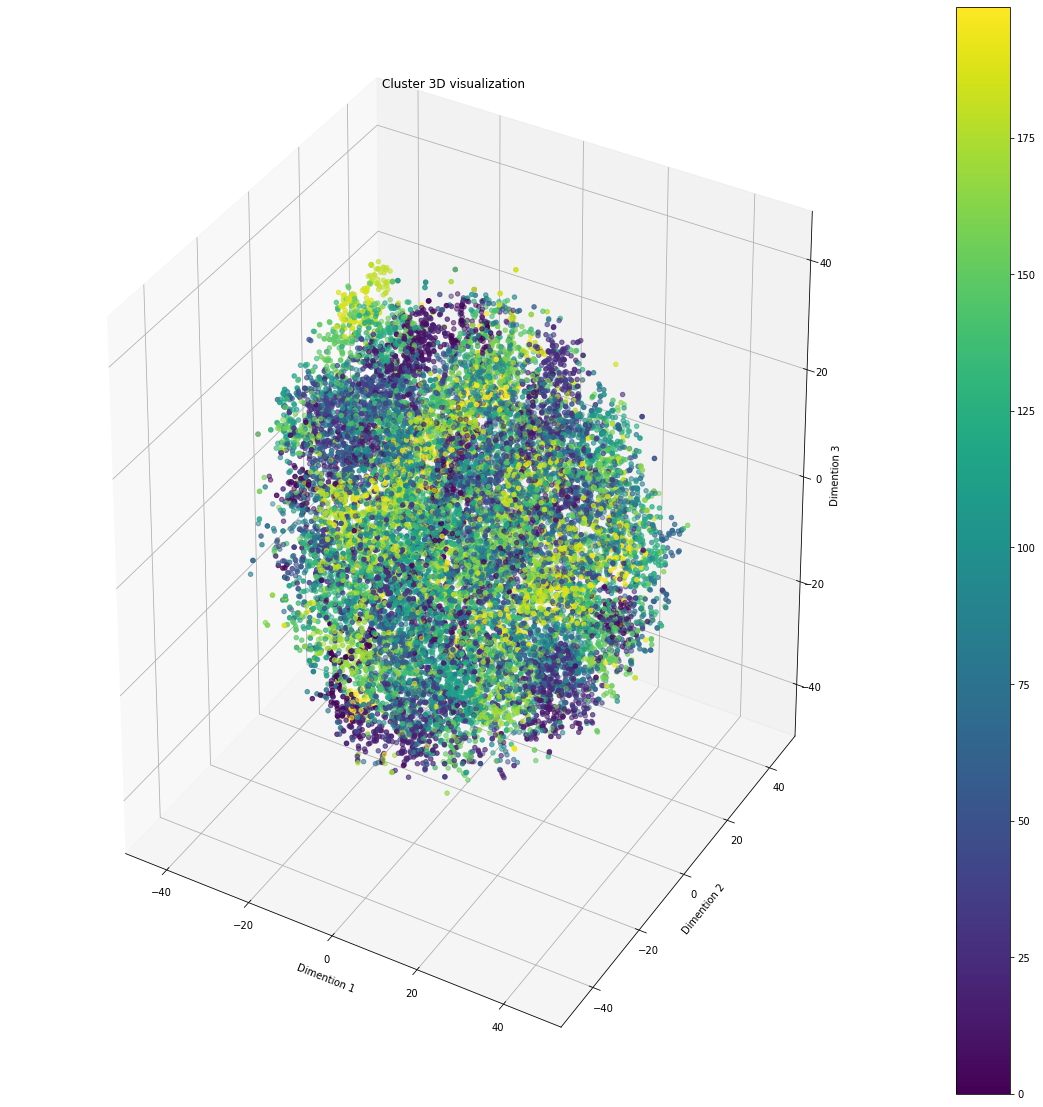

In [105]:
go=[item for sublist in allFeatures for item in sublist]
mo=pd.DataFrame(go)
pred=kmeans.predict(mo)
mo['cluster']= pred

X_embedded = TSNE(n_components=3).fit_transform(mo)
dataV=pd.DataFrame(X_embedded, columns=["D1","D2", "D3"])
dataV['cluster']=mo['cluster'].tolist()
dataV=dataV.loc[dataV["cluster"]>-1]
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111,projection='3d')
scatter = ax.scatter(dataV['D1'],dataV['D2'],dataV['D3'],
                  c=dataV['cluster'],   )
ax.set_title('Cluster 3D visualization')
ax.set_xlabel('Dimention 1')
ax.set_ylabel('Dimention 2')
ax.set_zlabel('Dimention 3')
plt.colorbar(scatter)


### Calculating TF IDF and creating BOW

In [47]:
alla=calcTf(kmeans, allFeatures)
documentsPerFeature=calcDocsPerFeature(alla,200)
fr=calcTfIdf(alla,documentsPerFeature)
fr

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,0.000000,0.011887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011411,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.039227,0.038179,0.000000,0.000000,0.012895,0.010499,0.000000,...,0.013260,0.000000,0.000000,0.000000,0.000000,0.013260,0.000000,0.027278,0.0,0.000000
2,0.009676,0.022784,0.000000,0.026151,0.000000,0.027278,0.012895,0.000000,0.020997,0.000000,...,0.013260,0.000000,0.030618,0.000000,0.011708,0.000000,0.010936,0.068194,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010609,0.014180,...,0.013400,0.027958,0.000000,0.012499,0.000000,0.026799,0.000000,0.000000,0.0,0.000000
4,0.000000,0.011512,0.000000,0.000000,0.009645,0.000000,0.000000,0.013030,0.010609,0.000000,...,0.026799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000000,0.011634,0.000000,0.013354,0.019496,0.000000,0.000000,0.000000,0.021444,0.014331,...,0.040627,0.000000,0.015635,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.014331
196,0.000000,0.011392,0.012033,0.000000,0.000000,0.000000,0.012895,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.037108,0.000000,0.013260,0.010936,0.000000,0.0,0.000000
197,0.000000,0.000000,0.012289,0.000000,0.000000,0.000000,0.026338,0.000000,0.000000,0.042992,...,0.000000,0.000000,0.031270,0.025265,0.000000,0.000000,0.000000,0.013929,0.0,0.000000
198,0.000000,0.000000,0.000000,0.000000,0.039410,0.000000,0.013310,0.000000,0.000000,0.072423,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [89]:
fr.sum().sort_values(ascending=False).head(30)

123    2.085444
8      1.764408
155    1.689109
13     1.618776
95     1.581571
58     1.546257
30     1.545799
85     1.515536
176    1.510791
40     1.503540
111    1.461741
54     1.439225
122    1.430150
66     1.423734
64     1.418996
151    1.412119
75     1.406532
126    1.398144
107    1.391148
42     1.385098
15     1.381780
198    1.357448
88     1.355706
133    1.354935
32     1.348031
20     1.346481
109    1.340843
84     1.324201
137    1.323893
91     1.317951
dtype: float64

### Visualizing fetuares in 3D dimention scatter plot
- dimention reduction is applied on number of documents


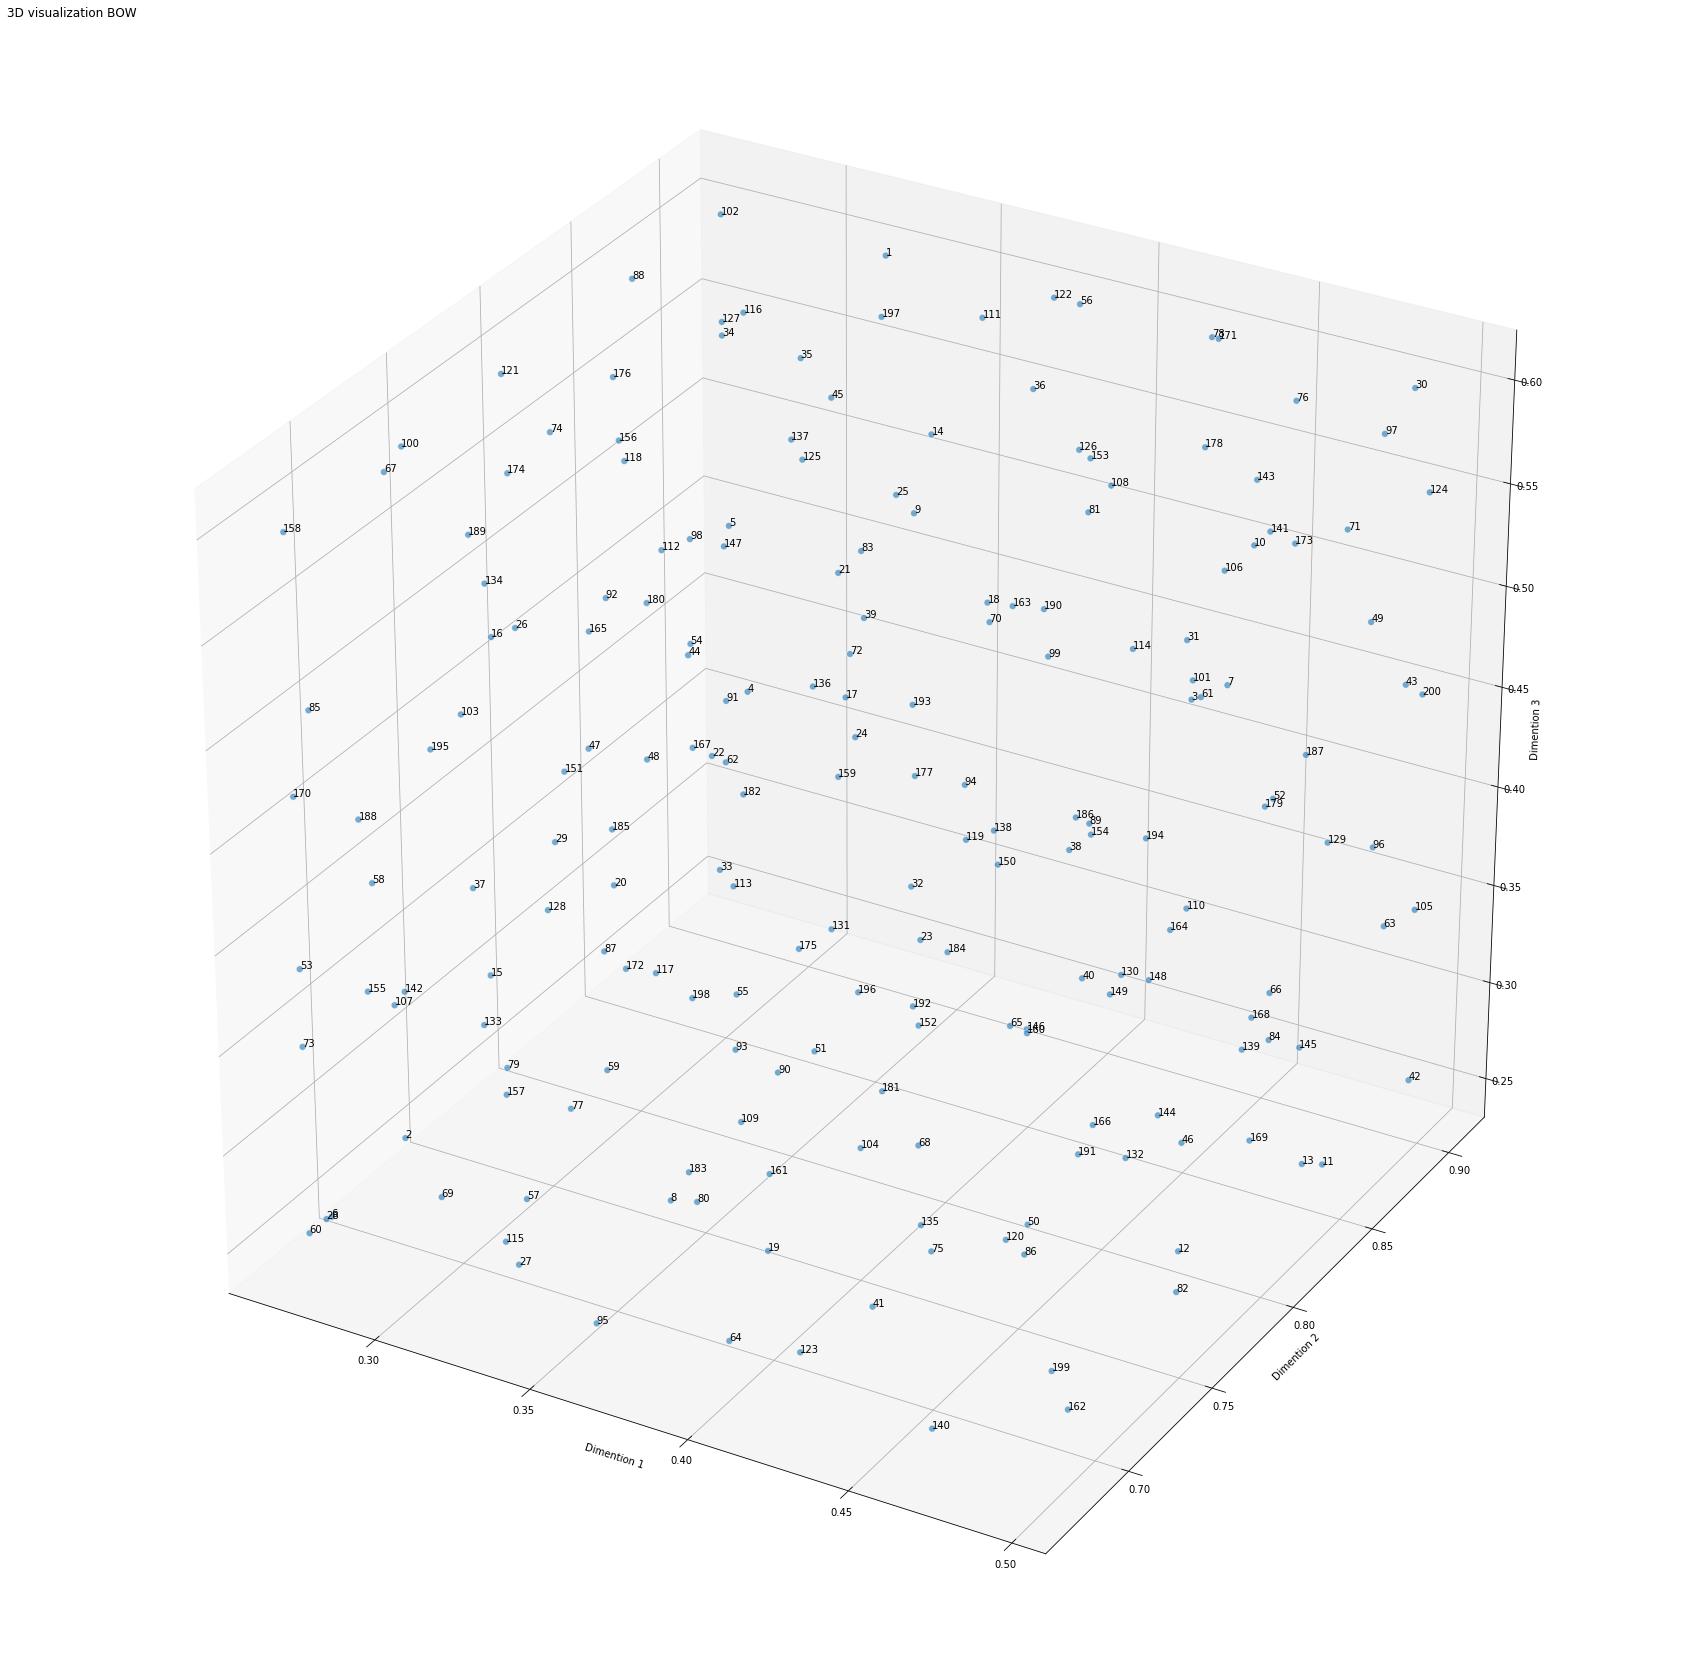

In [48]:
visualize(fr.T,fr.columns)

In [49]:
'''
y1=int(keypoints[0].pt[1]+keypoints[0].size/2)
y2=int(keypoints[0].pt[1]-keypoints[0].size/2)
x1= int(keypoints[0].pt[0]+keypoints[0].size/2)
x2=int(keypoints[0].pt[0]-keypoints[0].size/2)
crop_img = wholeImage[y2:y1,x2:x1]
cv2.imshow("cropped", crop_img)
cv2.waitKey(0)
'''

'\ny1=int(keypoints[0].pt[1]+keypoints[0].size/2)\ny2=int(keypoints[0].pt[1]-keypoints[0].size/2)\nx1= int(keypoints[0].pt[0]+keypoints[0].size/2)\nx2=int(keypoints[0].pt[0]-keypoints[0].size/2)\ncrop_img = wholeImage[y2:y1,x2:x1]\ncv2.imshow("cropped", crop_img)\ncv2.waitKey(0)\n'

## YELP API Data Extraction
- get reviews, sorted by rating, business located in Deli
- apply filter:rating <3 
- save in the corresponding file

In [73]:
import json
import requests
import csv

key='crsZaDRn86h5i2YZhSlC4XdB_vunuNAQzIbUIH_wf_zN5OugkI116aSvccoHMLN5DPVb1RJYwWJUq1ns4SbjmiTFmZVmJkl5wegiKt3qS-2YsOLUFevIv8cGdmhVXnYx'
headers = {
    'Authorization': 'Bearer '+key,
    'Content-Type': 'application/graphql',
}

data = '{search(sort_by:"reviews",location:"mainz" limit:50) {business { reviews{rating text} }}}'

response = requests.post('https://api.yelp.com/v3/graphql', headers=headers, data=data)

json_obj = json.loads(response.content)
json_obj



arr=[]

for i in json_obj['data']['search']['business']:
    for u in i['reviews']:
        if(len(u)>0 and u['rating']<3):
            arr.append({'rating':u['rating'],'text':u['text']})


pd.DataFrame(arr).to_csv('data.csv', mode='a', header=False, index= False)
arr

[{'rating': 1,
  'text': 'This place was extremely disappointing.  The food was overly seasoned and the fish tasted very old and gamy.\n\nThe service was even worse as a large party...'},
 {'rating': 1,
  'text': 'Definitely did not meet expectations. Was clean and looked decent from the outside, and prices seemed more than reasonable but usually things that are too...'},
 {'rating': 2,
  'text': 'I hate to rate this restaurant at 2 stars, however, after my recent experience last night I left disappointed. I visited this restaurant in November and...'},
 {'rating': 1,
  'text': "Cheap wanna be Japanese restaurant. It actually doesn't taste anything Japanese the only flavor is sweet and nothing feels fresh. It is actually expensive..."},
 {'rating': 2,
  'text': 'Had a quick bite to eat for dinner here.\nIt was busy with an assortment of people.\nThey had a. English menu which was great.\nFor starters my husband and I...'},
 {'rating': 2,
  'text': 'I was excited by the number of vegeta

In [112]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')